各種インポート及び環境変数の読み込み。

In [16]:
import os
from azure.ai.projects import AIProjectClient
from azure.ai.projects.models import CodeInterpreterTool
from azure.identity import AzureCliCredential
from typing import Any
from pathlib import Path
from dotenv import load_dotenv
from IPython.display import Image, display

load_dotenv()

print(os.environ["PROJECT_CONNECTION_STRING"])

eastus.api.azureml.ms;6426cfb2-925a-4aa7-82b9-955f3ad6d9ab;rg-eastus-agents;project-demo-zr6e


Agent のクライアントの作成

In [4]:
project_client = AIProjectClient.from_connection_string(
    credential=AzureCliCredential(), conn_str=os.environ["PROJECT_CONNECTION_STRING"]
)
# 通常は with 文を使うのが良いが、jpyter notebook では使えないので明示的に __enter__ を呼び出す
project_client.__enter__()

Code Interpreter tool を使用する AI Agent の作成

In [7]:
code_interpreter = CodeInterpreterTool()
# The CodeInterpreterTool needs to be included in creation of the agent
agent = project_client.agents.create_agent(
    model="gpt-4o-mini",
    name="my-agent",
    instructions="You are helpful agent",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)
print(f"Created agent, agent ID: {agent.id}")

Created agent, agent ID: asst_KP4JRxKAZN8qLAichzZEZQDr


会話のスレッドを作成

In [8]:
# Create a thread
thread = project_client.agents.create_thread()
print(f"Created thread, thread ID: {thread.id}")


Created thread, thread ID: thread_ob208XahMlhDO5wpzttRJcvx


メッセージを作成してエージェントの実行

In [25]:
# Create a message
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content="""
    以下のデータを使って、営業利益の棒グラフを作成し、ファイルを提供してください。
    会社A: 1億2000万円, 会社B: 2億5000万円, 会社C: 3億円, 会社D: 1億8000万円
    棒グラフ内のテキストは会社名や通貨の表記も全て英語で生成してください。
    """,
)
print(f"Created message, message ID: {message.id}")

# Run the agent
run = project_client.agents.create_and_process_run(thread_id=thread.id, assistant_id=agent.id)
print(f"Run finished with status: {run.status}")


Created message, message ID: msg_XNsrE5wmbsQcyzn5VjI6JIcp
Run finished with status: RunStatus.COMPLETED


メッセージの表示

In [26]:
# Get messages from the thread
messages = project_client.agents.list_messages(thread_id=thread.id)
print(f"Messages: {messages}")

# Get the last message from the sender
last_msg = messages.get_last_text_message_by_sender("assistant")
if last_msg:
    print(f"Last Message: {last_msg.text.value}")

# Generate an image file for the bar chart
for image_content in messages.image_contents:
    print(f"Image File ID: {image_content.image_file.file_id}")
    file_name = f"{image_content.image_file.file_id}_image_file.png"
    project_client.agents.save_file(file_id=image_content.image_file.file_id, file_name=file_name)
    print(f"Saved image file to: {Path.cwd() / file_name}")

Messages: {'object': 'list', 'data': [{'id': 'msg_dTQ0CadWtlYXjBT3qHHyNdE6', 'object': 'thread.message', 'created_at': 1736146540, 'assistant_id': 'asst_KP4JRxKAZN8qLAichzZEZQDr', 'thread_id': 'thread_ob208XahMlhDO5wpzttRJcvx', 'run_id': 'run_GLNiPwQHDmPfceQQy0BqVkg0', 'role': 'assistant', 'content': [{'type': 'text', 'text': {'value': '営業利益の棒グラフを作成しました。会社名や通貨の表記が全て英語で生成されています。以下のリンクからダウンロードできます。\n\n[Download Operating Profit Chart](sandbox:/mnt/data/operating_profit_chart_full_en.png)', 'annotations': [{'type': 'file_path', 'text': 'sandbox:/mnt/data/operating_profit_chart_full_en.png', 'start_index': 96, 'end_index': 148, 'file_path': {'file_id': 'assistant-RhA4lO0E1AYLjfgxkNvMCEgI'}}]}}], 'attachments': [{'file_id': 'assistant-RhA4lO0E1AYLjfgxkNvMCEgI', 'tools': [{'type': 'code_interpreter'}]}], 'metadata': {}}, {'id': 'msg_XNsrE5wmbsQcyzn5VjI6JIcp', 'object': 'thread.message', 'created_at': 1736146534, 'assistant_id': None, 'thread_id': 'thread_ob208XahMlhDO5wpzttRJcvx', 'run_id': 

ファイルのダウンロードと表示

File Paths:
Type: file_path
Text: sandbox:/mnt/data/operating_profit_chart_full_en.png
File ID: assistant-RhA4lO0E1AYLjfgxkNvMCEgI
Start Index: 96
End Index: 148


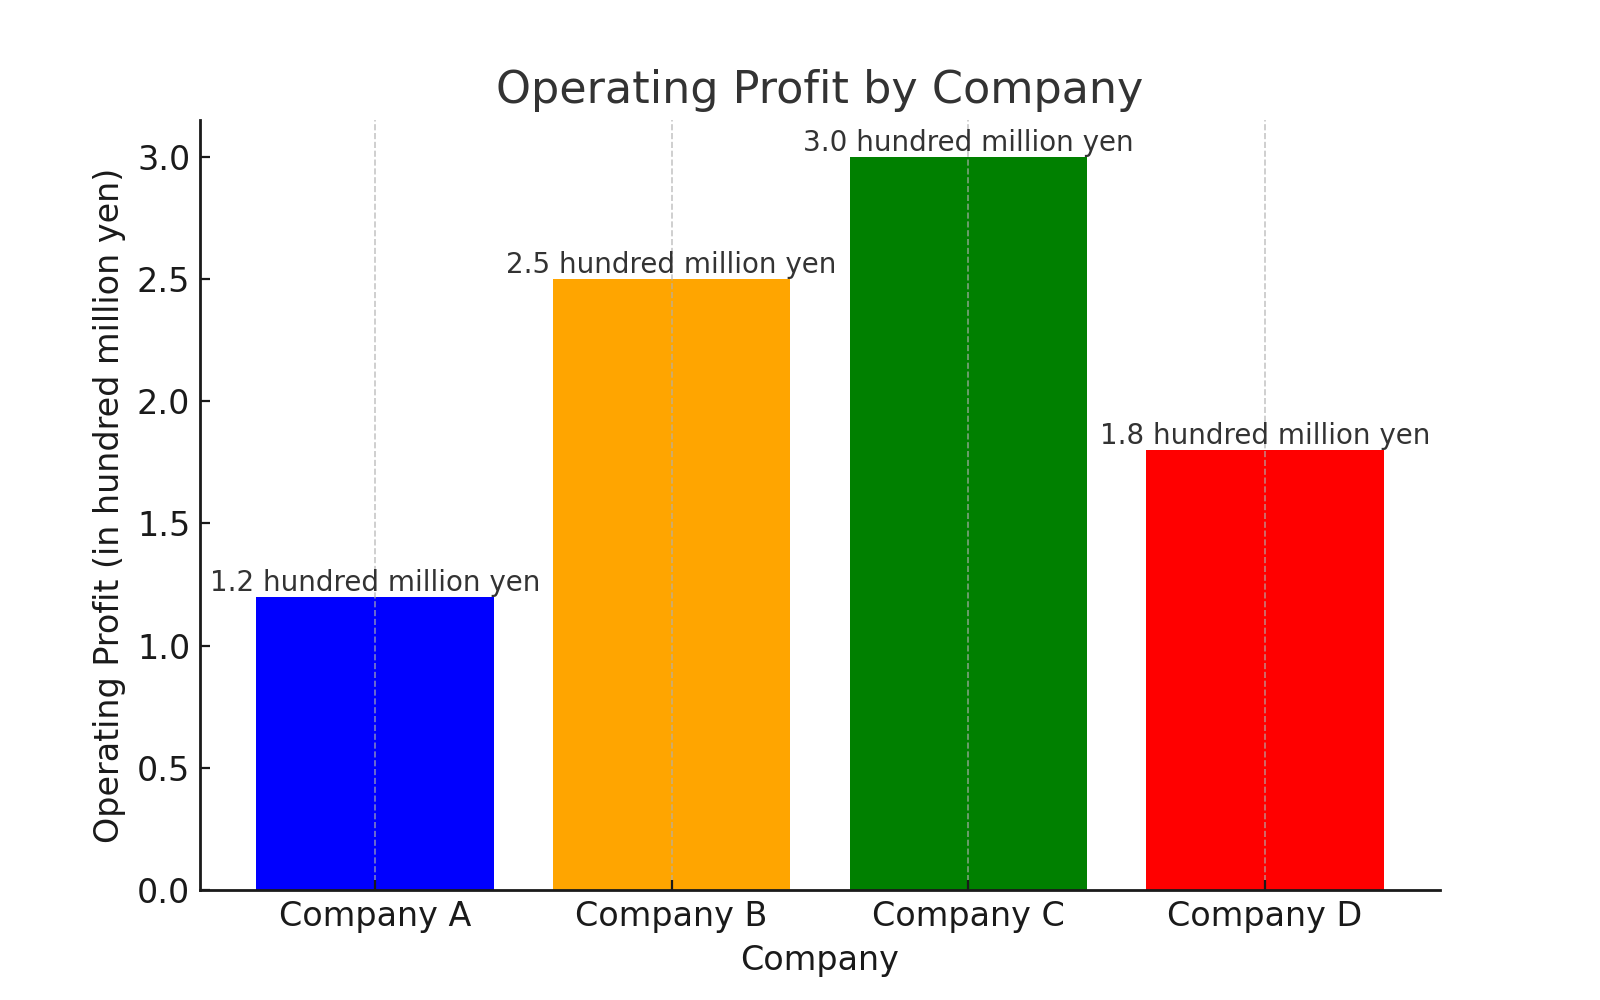

File Paths:
Type: file_path
Text: sandbox:/mnt/data/operating_profit_chart_ja_en.png
File ID: assistant-87ZtOlr0lb5xaxlD7cJtjX9J
Start Index: 93
End Index: 143


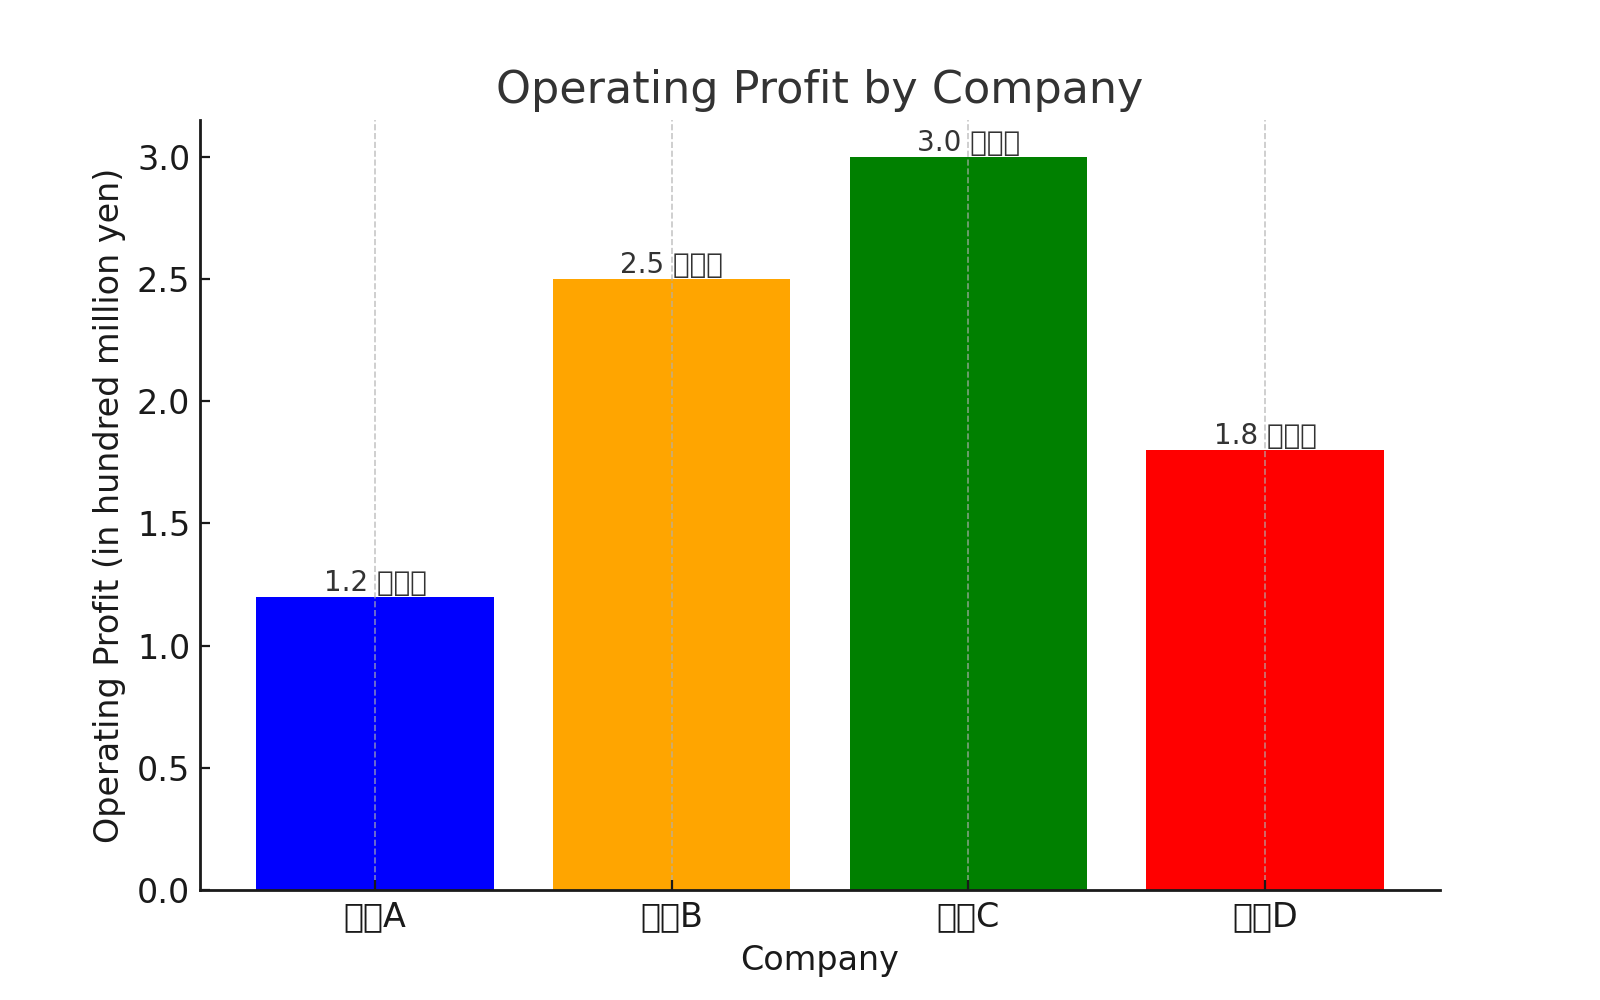

File Paths:
Type: file_path
Text: sandbox:/mnt/data/operating_profit_chart_ja.png
File ID: assistant-Y5PoOQm4U17diarjtFQK2MVP
Start Index: 56
End Index: 103


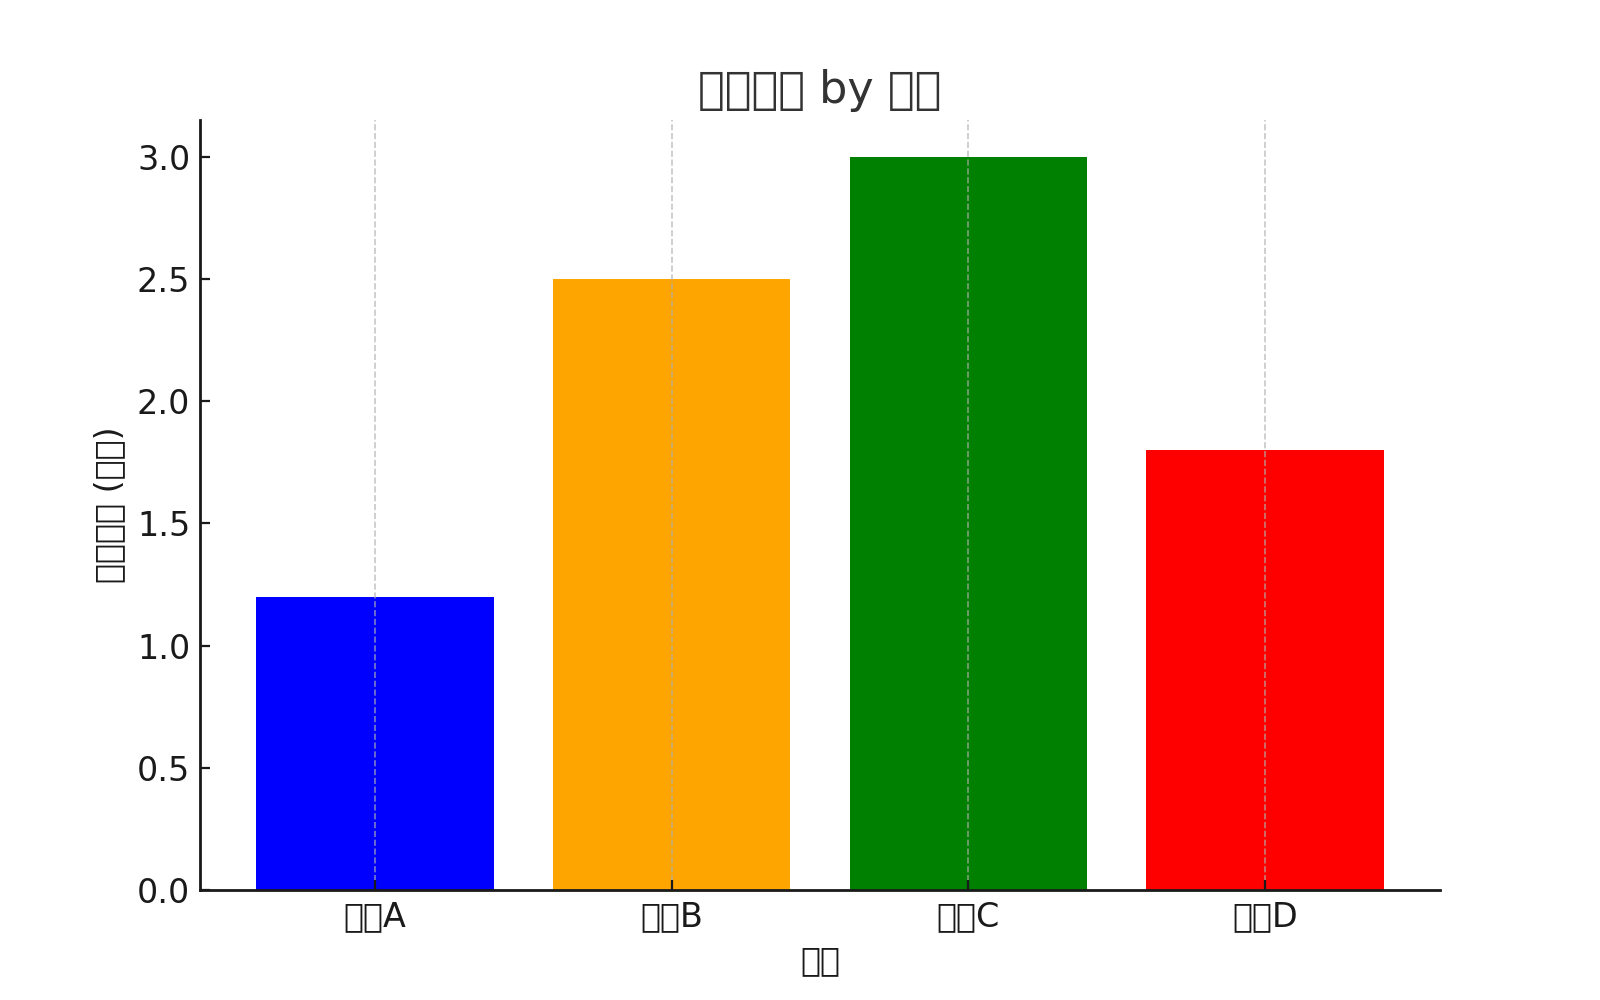

File Paths:
Type: file_path
Text: sandbox:/mnt/data/operating_profit_chart.png
File ID: assistant-33LcNM7CpO3m2gWN4Y8So2mS
Start Index: 132
End Index: 176


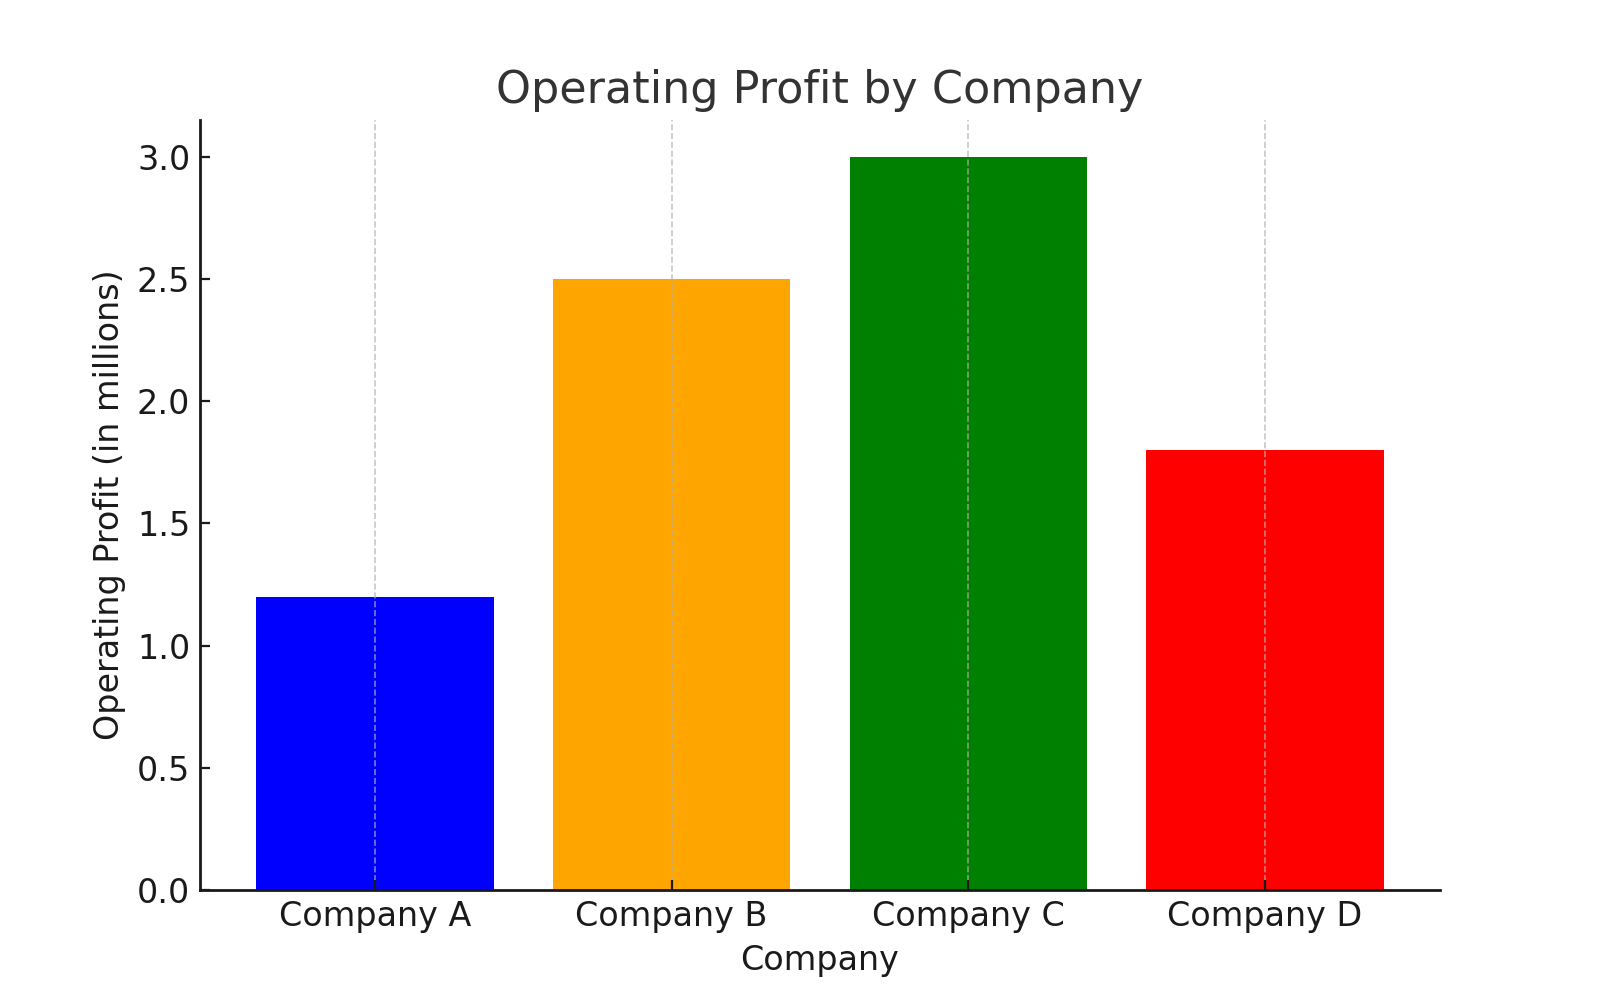

In [27]:
# Print the file path(s) from the messages
for file_path_annotation in messages.file_path_annotations:
    print(f"File Paths:")
    print(f"Type: {file_path_annotation.type}")
    print(f"Text: {file_path_annotation.text}")
    print(f"File ID: {file_path_annotation.file_path.file_id}")
    print(f"Start Index: {file_path_annotation.start_index}")
    print(f"End Index: {file_path_annotation.end_index}")
    project_client.agents.save_file(file_id=file_path_annotation.file_path.file_id, file_name=Path(file_path_annotation.text).name)
    display(Image(filename=Path(file_path_annotation.text).name))


In [28]:
project_client.agents.delete_agent(agent.id)
# リソースの解放
project_client.close()
print("Deleted agent")

ValueError: HTTP transport has already been closed. You may check if you're calling a function outside of the `with` of your client creation, or if you called `close()` on your client already.